In [1]:
%load_ext autoreload
%autoreload 2

import torch
import wandb_util.wandb_util as wbu

torch.set_grad_enabled(False)

In [2]:
from omegaconf import OmegaConf
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.artifacts.texture_artifact import TextureArtifact
from text3d2video.rendering import render_texture
import torchvision.transforms.functional as TF

from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

texture_tag = "cat_statue_mvlatest_SilverCatStatue:v0"
texture_art = TextureArtifact.from_wandb_artifact_tag(texture_tag)
texture = texture_art.read_texture()

texture_run = texture_art.logged_by()
config = OmegaConf.create(texture_run.config)
prompt = config.prompt

anim = wbu.used_artifacts(texture_run)[0]
anim = AnimationArtifact.from_wandb_artifact(anim)
cams, meshes = anim.load_frames()
verts_uvs, faces_uvs = anim.uv_data()

renders = render_texture(meshes, cams, texture, verts_uvs, faces_uvs)
renders_pil = [TF.to_pil_image(r.cpu()) for r in renders]

display_vids([pil_frames_to_clip(renders_pil)], titles=[prompt])

In [3]:
from text3d2video.pipelines.controlnet_pipeline import BaseControlNetPipeline
from text3d2video.pipelines.pipeline_utils import load_pipeline

pipe = load_pipeline(BaseControlNetPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [105]:
from text3d2video.pipelines.texgen_pipeline import TexGenLogic

texgen = TexGenLogic(pipe)

In [110]:
texgen.precompute_projections(cams, meshes, verts_uvs, faces_uvs)

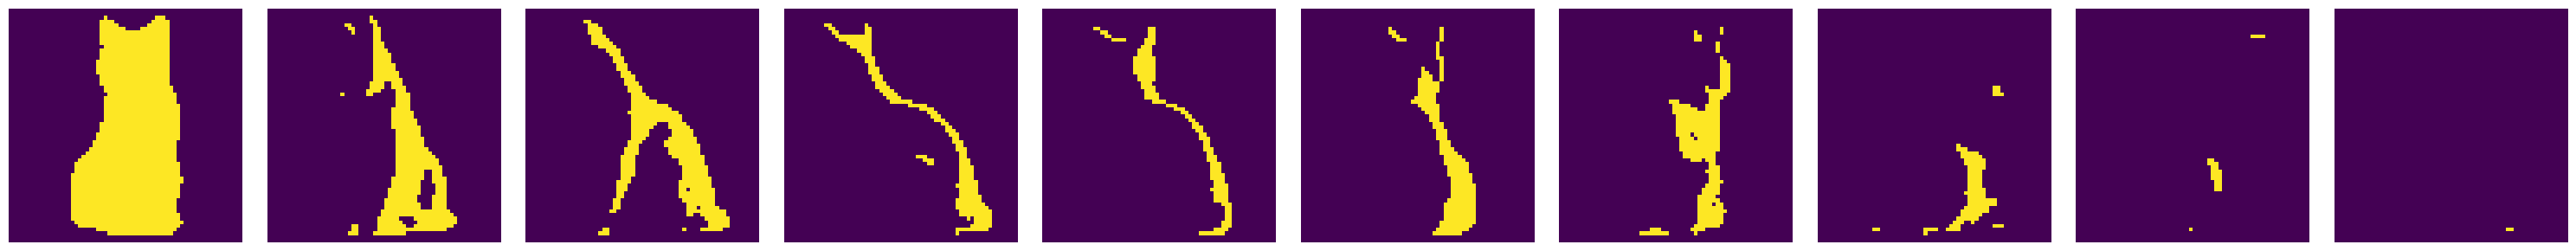

In [112]:
from text3d2video.utilities.ipython_utils import display_ims

newly_visible_masks = texgen.newly_visible_masks.cpu()

display_ims(newly_visible_masks)